In [16]:
%load_ext autoreload
%autoreload 2
%connect_info
%pprint 1
import sys
sys.path.append('..')
from dno.proto.mock import MockInterop, TaskReader
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from dno.proto.data import Task, Map
from collections import defaultdict
from pathlib import Path
from typing import Union, Tuple, List, Sequence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{
  "shell_port": 61133,
  "iopub_port": 61134,
  "stdin_port": 61135,
  "control_port": 61136,
  "hb_port": 61137,
  "ip": "127.0.0.1",
  "key": "eaae9283-2129bc65f5960544b8dec071",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b8f64b61-6278-448c-afa6-543b624a6daf.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
Pretty printing has been turned ON


In [2]:
task_num = 1
tr = TaskReader("..\\data\\besthack19\\task" + str(task_num))

In [3]:
map_raw, data_raw, score = tr.read_all()
n = int(sqrt(len(map_raw["map"])))
map_arr = Map.from_dict(map_raw).data
print(map_arr)

[[17132 17573 18053 ... 54525 54607 54668]
 [16909 17303 17601 ... 54533 54615 54659]
 [16832 17129 17230 ... 54591 54651 54643]
 ...
 [ 4179  4158  4048 ... 48801 48886 48933]
 [ 4042  4049  3945 ... 48710 48736 48777]
 [ 3911  3946  3881 ... 48562 48652 48793]]


In [4]:
flight = {"X":int(n/2), "Y":int(n/2)}
delta = {"X":0, "Y":0}
flight_hist = {"X":[], "Y":[]}
prepre = {"X":[], "Y":[]}

In [5]:
import copy
from math import fabs

delt = {"X":1, "Y":1}
predict = []
for data in data_raw:
    d = data["data"]
    parsed = Task.from_dict(d)
    flight_hist["X"].append(parsed.x)
    flight_hist["Y"].append(parsed.y)
    flight["X"] += parsed.vx
    flight["Y"] += parsed.vy
    prepre["X"].append(flight["X"])
    prepre["Y"].append(flight["Y"])
    delta["X"] += parsed.vx
    delta["Y"] += parsed.vy
    for coord in ["X", "Y"]:
        if fabs(delta[coord]) >= n/(delt[coord] + 1):
            flight[coord] -= delta[coord]
            delta[coord] = fabs(delta[coord]) - n/(delt[coord] + 1)
            delt[coord] += 1

[<matplotlib.lines.Line2D object at 0x00000179085CBDD8>, <matplotlib.lines.Line2D object at 0x00000179085CBFD0>]

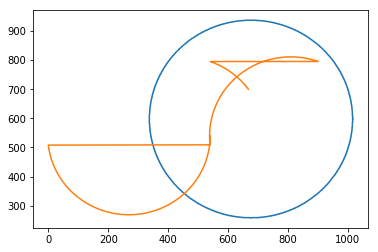

In [6]:
plt.plot(flight_hist["X"], flight_hist["Y"], prepre["X"], prepre["Y"])

[<matplotlib.lines.Line2D object at 0x0000017908678518>, <matplotlib.lines.Line2D object at 0x0000017908678710>]

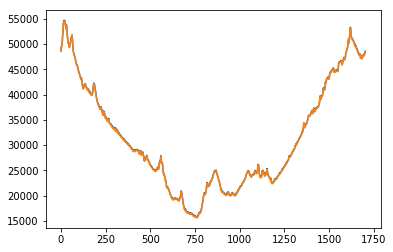

In [7]:
height_hist = []
land_height = []
for data in data_raw:
    d = data["data"]
    parsed = Task.from_dict(d)
    height_hist.append(d["height"])
    land_height.append(map_arr[parsed.y][parsed.x])
plt.plot(range(0, len(data_raw)), height_hist, range(0, len(data_raw)), land_height)

In [8]:
def get_candidates(data, map_arr, c=204):
    candidates = []
    d_height = data["height"]
    for i in range(0, n):
        for j in range(0, n):
            delta = d_height - map_arr[j][i]
            if delta > 0 and delta <= 200:
                candidates.append([j, i])
    return candidates

candidates = get_candidates(data_raw[0]["data"], map_arr)
print(len(candidates))

2325


Max delta: 203. Task [1]: std=17.75206378541896, mean=142.2406103286385
Max delta: 98. Task [2]: std=17.85721005058036, mean=27.67247386759582
Max delta: 247. Task [3]: std=17.54023060044629, mean=-176.1904761904762
Max delta: 137. Task [4]: std=17.71786229931099, mean=-67.7995867768595
Max delta: 336. Task [5]: std=17.955677870912243, mean=-278.0012738853503
Max delta: 133. Task [6]: std=17.760408968607067, mean=-81.10276679841897
Max delta: 189. Task [7]: std=17.437458693708322, mean=128.8529209621993
Max delta: 194. Task [8]: std=18.07544007763147, mean=-129.52293577981652
Max delta: 111. Task [9]: std=18.25654306827272, mean=-60.46700507614213


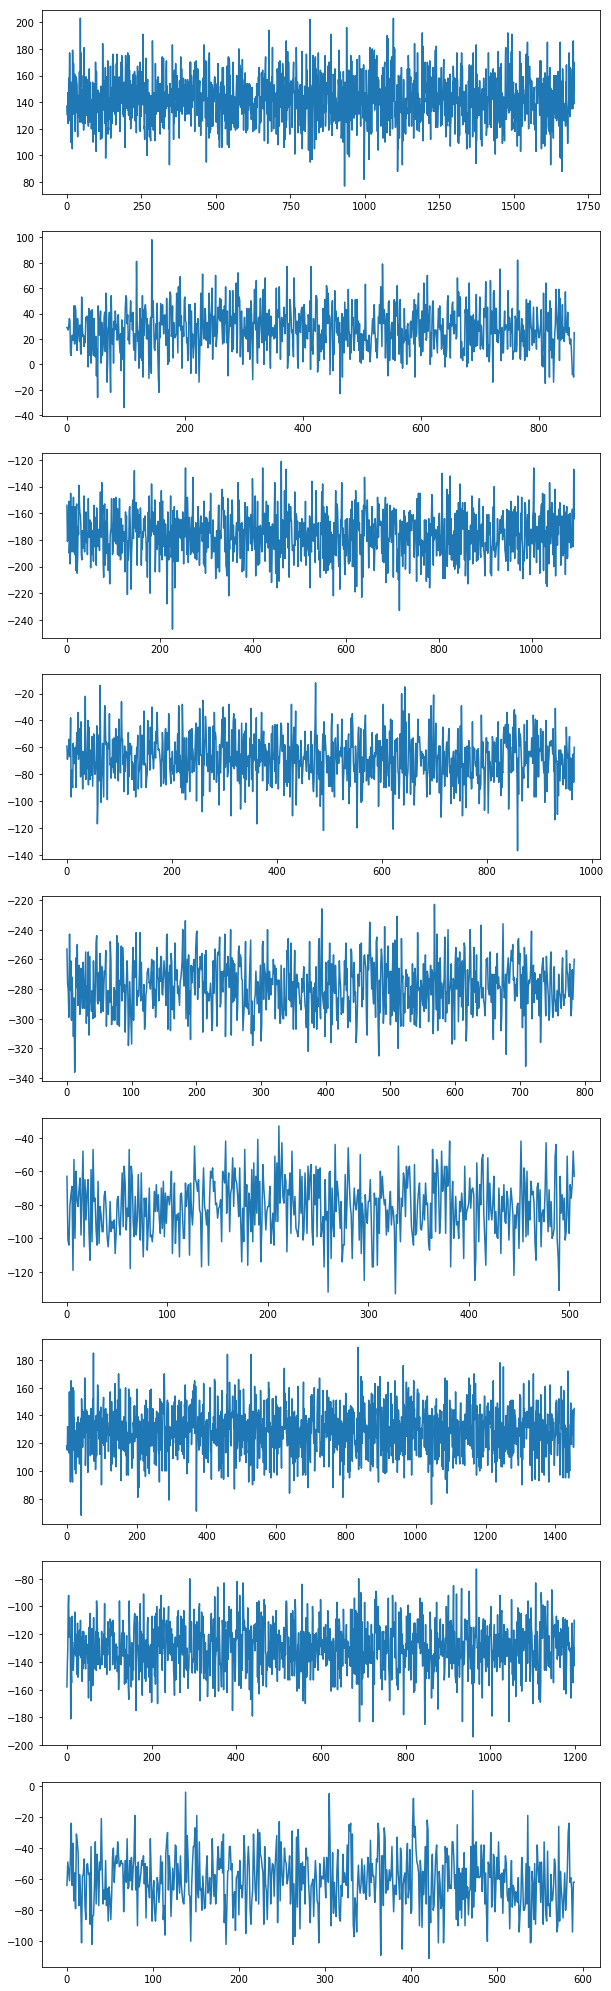

In [43]:
max_delta = 0
deltas = defaultdict(list)

def count_deltas(map_data: Map, tasks: List[Task], task_name: str) -> Tuple[int, List[int]]:
    task_deltas = []
    max_delta = 0
    for task in tasks:
        point_h = map_data[task.y, task.x]
        delta = task.height - point_h
        task_deltas.append(delta)
        #if delta < 0:
            #print(f"Negative delta: {delta}. Task {task} for point [{task.x}, {task.y}]")
            #raise ValueError(f"CHTO? Negative task delta for task {task_name}, task={task}")
        max_delta = max(abs(delta), max_delta)
    print(f"Max delta: {max_delta}. Task [{task_name}]: std={np.std(task_deltas)}, mean={np.mean(task_deltas)}")
    return max_delta, task_deltas


deltas = {
    
}
for task_num in range(1, 10):
    path = Path("..\\data\\besthack19\\") / f"task{task_num}"
    #print(path)
    t = TaskReader(path)
    map_raw, data_raw, _ = t.read_all()
    #print(len(data_raw))
    negative = 0
    map_array = Map.from_dict(map_raw).data
    _, deltas[task_num] = count_deltas(map_array, [Task.from_dict(data_point['data']) for data_point in data_raw], task_name=task_num)

fig, axs = plt.subplots(nrows=len(deltas), ncols=1, figsize=(10, 4*len(deltas)))
for task_name, delta_values in deltas.items():
    #print(len(delta_values))
    axs[task_name-1].plot(range(len(delta_values)), delta_values)
plt.show()

In [73]:
from math import sqrt

class PetrFinder:
    def __init__(self, map_raw, c = 204):
        self.n = sqrt(len(map_raw["map"]))
        self.map_arr = np.array(map_raw["map"]).reshape(n, n)
        self.candidates = []
        self.c = c
        
    def handle_task(self, task: Task):
        if not self.candidates:
            self.candidates = self.init_candidates(task)
        else:
            self.candidates = self.filter_by_task(task)
            
    def init_candidates(self, task: Task):
        for i in range(0, n):
            for j in range(0, n):
                delta = task.height - self.map_arr[j][i]
                if delta > 0 and delta <= self.c:
                    candidates.append([j, i])
        return candidates
    
    def filter_by_task(self, task: Task):
        next_candidates = []
        for candidate in candidates:
            next_x = candidate[0] + task.vx 
            next_y = candidate[1] + task.vy
            try:
                delta = task.height - self.map_arr[next_x][next_y]
                if delta > 0 and delta < self.c:
                    next_candidates.append([next_x, next_y])
            except IndexError:
                continue
        return next_candidates

In [74]:
pf = PetrFinder(map_raw)
for data in data_raw:
    d = Task.from_dict(data["data"])
    pf.handle_task(d)
    print(len(pf.candidates))

4698
0
7163
0
9455
0


KeyboardInterrupt: 